## The effect of the _"Black Lives Matter"_ movement on the arrestation of African American people in L.A.

____

### Context _(TODO)_

...

Black Lives Matter movement created in July, 2013
___

### The data _(TODO)_

- Where it was acquired
- Explanation of each column

___

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

arrest_data = pd.read_csv('arrest-data-from-2010-to-present.csv', error_bad_lines = False)

Now that we've loaded our data, let's have a sneak peek at our dataframe

In [2]:
arrest_data.head()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,...,Charge Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,5666847,2019-06-22T00:00:00.000,1630.0,14,Pacific,1457,44,M,W,24.0,...,VANDALISM,12300 CULVER BL,NaN,"{'latitude': '33.992', 'human_address': '{""add...",24031.0,918.0,1137.0,10.0,10.0,85.0
1,5666688,2019-06-22T00:00:00.000,1010.0,10,West Valley,1061,8,M,O,NaN,...,NaN,19000 VANOWEN ST,NaN,"{'latitude': '34.1687', 'human_address': '{""ad...",19339.0,321.0,1494.0,NaN,4.0,10.0
2,5666570,2019-06-22T00:00:00.000,400.0,15,N Hollywood,1543,31,F,O,22.0,...,DRUNK DRIVING ALCOHOL/DRUGS,MAGNOLIA AV,LAUREL CANYON BL,"{'latitude': '34.1649', 'human_address': '{""ad...",8890.0,205.0,1332.0,17.0,5.0,39.0
3,5666529,2019-06-22T00:00:00.000,302.0,17,Devonshire,1738,23,F,W,22.0,...,DRUNK DRIVING ALCOHOL/DRUGS,HAYVENHURST ST,N REGAN FY,"{'latitude': '34.2692', 'human_address': '{""ad...",19329.0,69.0,388.0,NaN,2.0,78.0
4,5666742,2019-06-22T00:00:00.000,1240.0,14,Pacific,1472,28,M,W,8.0,...,OBSTRUCT/RESIST EXECUTIVE OFFICER,6600 ESPLANADE ST,NaN,"{'latitude': '33.9609', 'human_address': '{""ad...",25075.0,937.0,241.0,10.0,10.0,16.0


For our analysis, it is not important to keep all columns. Only the ones regarding the race, the date of the arrest, the gender and the type of arrest (i.e. infraction or felony) are of interest to us.

In [3]:
#Picking the necessary columns and renaming them
arrest_data = arrest_data[['Arrest Date', 'Sex Code', 'Descent Code', 'Arrest Type Code']] \
                .rename(columns = {'Arrest Date' : 'Date', 'Sex Code': 'Gender', 'Descent Code': 'Race', 
                                   'Arrest Type Code': 'Arrest Type'})


#Date --> DateTime
arrest_data['Date'] = pd.to_datetime(arrest_data['Date'], errors='coerce')

#Verifying the non of the dates are 'NaT' (Not a Time)
assert(arrest_data.Date.isnull().sum() == 0)

#Sanity checks
assert(datetime.datetime(2010,1,1) == min(arrest_data.Date))
assert(datetime.datetime(2019,6,22) == max(arrest_data.Date))

arrest_data.head()

,Date,Gender,Race,Arrest Type
0,2019-06-22,M,W,M
1,2019-06-22,M,O,O
2,2019-06-22,F,O,M
3,2019-06-22,F,W,M
4,2019-06-22,M,W,F


___

### Question 1

_Since the creation of the Black Lives Matter movement, was there a change in the trend of the overall arrests of African American people in L.A.?_

Let's start by looking at the number of arrests per race, just to get an idea of what that looks like

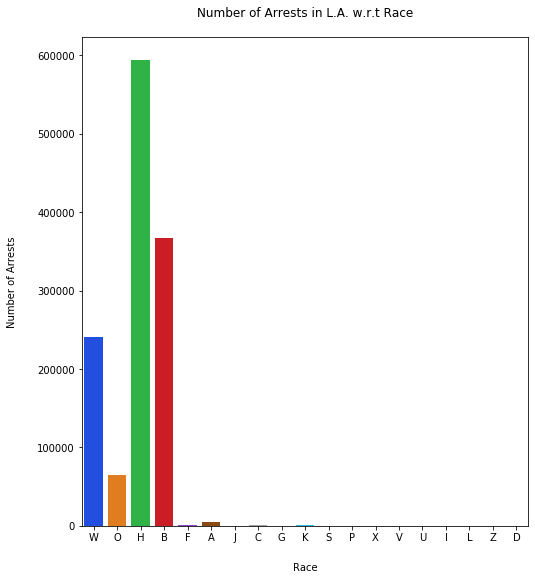

Number of Black people arrested (2010-2019) :  367152
Percentage: 28.77%

Number of Hispanic people arrested (2010-2019) : 594321
Percentage: 46.571%

Number of White people arrested (2010-2019) : 240451
Percentage: 18.842%

Number of Others people arrested (2010-2019) : 65426
Percentage: 5.127%



In [4]:
race_data = arrest_data[['Date', 'Race']]

fig = plt.figure(figsize=(8,9))
ax = plot = sns.countplot(x='Race', data= race_data, palette = 'bright')
plt.title("Number of Arrests in L.A. w.r.t Race", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Race', labelpad = 20)
plt.show()

#Getting count for each race that has a high number of arrests (> 5%)
counts = race_data.Race.value_counts()
black_counts = counts['B']
hispanic_counts = counts['H']
white_counts = counts['W']
others_counts = counts['O']

print('Number of Black people arrested (2010-2019) :  ' + str(black_counts))
print('Percentage: ' + str(round(black_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of Hispanic people arrested (2010-2019) : ' + str(hispanic_counts))
print('Percentage: ' + str(round(hispanic_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of White people arrested (2010-2019) : ' + str(white_counts))
print('Percentage: ' + str(round(white_counts/len(arrest_data)*100,3)) + "%\n")
print('Number of Others people arrested (2010-2019) : ' + str(others_counts))
print('Percentage: ' + str(round(others_counts/len(arrest_data)*100,3)) + "%\n")


We can already see that there is quite a decrepency in the number of arrests w.r.t the gender.

Now, let's look at how the creation of the Black Lives Matter movement affected the number of arrest. We will by counting the number of African American people arrested before and after July, 2013 (from January 2010 to December 2016, i.e. 3.5 years before and after the creation of the black lives matter)

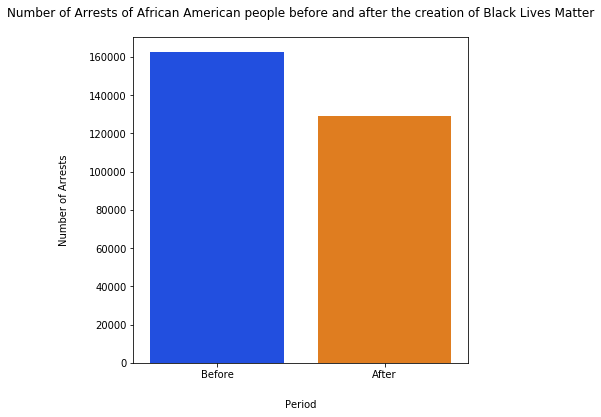

In [5]:
black_data = race_data[race_data['Race'] == 'B']
movement_creation_date = datetime.datetime(2013, 7, 13)
black_before_movement = black_data[black_data['Date'] <= movement_creation_date].assign(Period = "Before")
black_after_movement = black_data[(black_data['Date'] > movement_creation_date) & 
                                  (black_data['Date'] <= datetime.datetime(2016,12,31))].assign(Period = "After")

fig = plt.figure(figsize=(6,6))
ax = plot = sns.countplot(x='Period', data= pd.concat([black_before_movement, black_after_movement]), palette = 'bright')
plt.title("Number of Arrests of African American people before and after the creation of Black Lives Matter", pad = 20)
plt.ylabel('Number of Arrests', labelpad = 20)
plt.xlabel('Period', labelpad = 20)
plt.show()


At first glance, it would seem that the creation of the Black Lives Matter movment had a clear impact on the number of arrests of people of African American descent.  

In [6]:
print('Number of Arrests Before : ' + str(len(black_before_movement)))
print('Number of Arrests After  : ' + str(len(black_after_movement)))
print('Decrease percentage : ' + str(round((len(black_before_movement)- len(black_after_movement))/len(black_before_movement)*100,2)) + "%")

Number of Arrests Before : 162491
Number of Arrests After  : 129216
Decrease percentage : 20.48%


Analysis of the arrests trends per month --> segmented regression

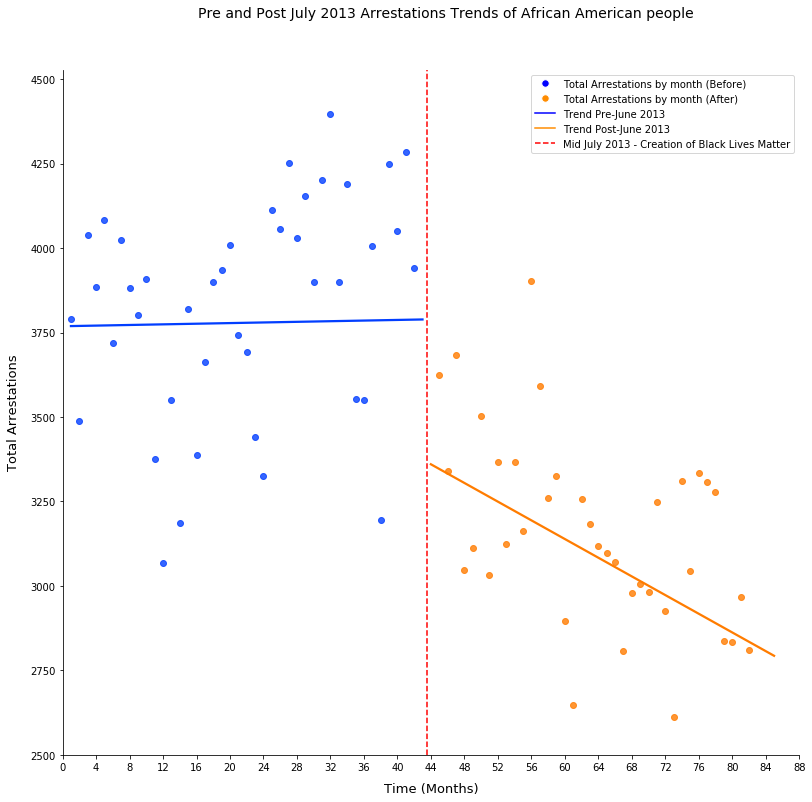

In [10]:
test = black_before_movement.set_index('Date')
test.replace('B', 1).groupby(pd.Grouper(freq = 'M')).sum()

black_trends_before = black_before_movement.set_index('Date') \
                        .replace('B', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'Before')

black_trends_after = black_after_movement.set_index('Date') \
                        .replace('B', 1) \
                        .rename(columns = {'Race' : 'Arrestations'}) \
                        .groupby(pd.Grouper(freq = 'M')).sum() \
                        .assign(Period = 'After')

black_trends = pd.concat([black_trends_before, black_trends_after]).reset_index(drop = True)
black_trends['Time'] = black_trends.index + 1


from matplotlib.lines import Line2D
#Showing the results of the segmented linear regression
ax = sns.lmplot(x="Time", y="Arrestations", hue = "Period", data=black_trends, ci=None, palette="bright", height = 12, 
                aspect = 1.0)
ax._legend.remove()
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Pre and Post July 2013 Arrestations Trends of African American people', fontsize = 14)
ax.set_axis_labels("Time (Months)", "Total Arrestations", fontsize = 13, labelpad = 10)
plt.axvline(x = 43.5, color = 'red', alpha = 2, linestyle = '--')
plt.xlim(0, 86)
plt.ylim(2500, None)
ax.set(xticks = range(0, 92, 4))

#Constructing the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Total Arrestations by month (Before)', markerfacecolor='blue', markersize=7.5),
                   Line2D([0], [0], marker='o', color='w', label='Total Arrestations by month (After)', markerfacecolor='darkorange', markersize=7.5),
                   Line2D([0], [0], color='blue', label = "Trend Pre-June 2013"), 
                   Line2D([0], [0], color='darkorange', label = "Trend Post-June 2013"), 
                   Line2D([0], [0], color='red', linestyle = '--', alpha = 2 , label = "Mid July 2013 - Creation of Black Lives Matter")]

plt.legend(handles=legend_elements)


plt.show()

**ATTENTION : Il y a des outliers (des mois qui ont moins de 2500 arrestations), mais je suis pas sûr qu'il faut les remove**